In [1]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [2]:
# visualization function

def show(tensor, ch=1, size=(28,28), num=16):
  #tensors: 128 * 784 (batchsize * num of pixels(28*28))
  data=tensor.detach().cpu().view(-1,ch,*size)
  grid=make_grid(data[:num],nrow=4).permute(1,2,0)  #permute is to reshape from torch shape to matplot lib shape
  plt.imshow(grid)
  plt.show()


In [3]:
#setup of the main and hyper parameter
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),shuffle=True,batch_size=bs)

#number of steps in each epoch = 60000 /128 = 468.75 (number of images/batchsize)

100%|██████████| 9912422/9912422 [00:00<00:00, 106169365.64it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43683986.23it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23475212.14it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7638544.01it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# relu or any activation function introduces non linearity in the model
# Generator class params --- > size of input noise or latent vector = 64, output vector size = 784(28*28 mnist data size), base size of the first hidden layer of network
# Discriminator class params --- > dimension of the image, default size of hidden layer

def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace = True)
  )


## Generator
class Generator(nn.Module):
  def __init__(self,z_dim=64,i_dim=784,h_dim=128):
    super().__init__()    # initializing the parent class
    self.gen = nn.Sequential(
        genBlock(z_dim,h_dim),   # 64, 128
        genBlock(h_dim, h_dim*2),  # 128, 256
        genBlock(h_dim *2, h_dim *4), # 256, 512
        genBlock(h_dim*4, h_dim*8),  # 512, 1024
        nn.Linear(h_dim *8, i_dim),   # 1024, 784(28,28)
        nn.Sigmoid()  # to make the output between 0 and 1
    )

  def forward(self,noise):
    return self.gen(noise)


def gen_noise(number,z_dim):
  return torch.randn(number,z_dim).to(device)    # store the output in gpu



## Discriminator
def discBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self,i_dim=784,h_dim=256):
    super().__init__()
    self.disc = nn.Sequential(
        discBlock(i_dim,h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024,512
        discBlock(h_dim*2, h_dim),  # 512, 256
        nn.Linear(h_dim,1)  # 256,1
     )

  def forward(self,image):
      return self.disc(image)

In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr=lr)

In [6]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [7]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([8, 6, 2, 8, 9, 7, 2, 4, 1, 8])


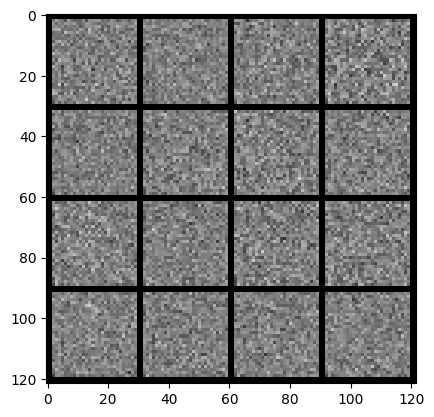

In [8]:
x,y=next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])

noise = gen_noise(bs,z_dim)
fake=gen(noise)
show(fake)

In [9]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func,gen,disc,number,z_dim):
  noise = gen_noise(number,z_dim)  # number is the batch size
  fake=gen(noise)
  pred = disc(fake)
  targets =torch.ones_like(pred)   # this will create a vector with dim similar to pred, generator must be able to full the disc, hence the disc actual o/p must be 1
  gen_loss=loss_func(pred,targets)
  return gen_loss

# discriminator loss
def calc_disc_loss(loss_func,gen,disc,number,real,z_dim):
  noise = gen_noise(number,z_dim)
  fake = gen(noise)
  disc_fake=disc(fake.detach()) # detach because we dont want to change the parameters of generator(while back propogates)
  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake,disc_fake_targets)

  disc_real=disc(real)
  disc_real_targets=torch.ones_like(disc_real)
  disc_real_loss=loss_func(disc_real,disc_real_targets)
  disc_loss=(disc_fake_loss+disc_real_loss)/2
  return disc_loss

In [10]:
epochs = 70

In [13]:
# 600000 / 128 = 468.75 = 469 steps in each epoch
# each step is going to process 128 images = size of the batch(except the last step)

for epoch in range(epochs):
  for real,_ in tqdm(dataloader):
    # discriminator
    disc_opt.zero_grad()

    cur_bs=len(real)  # real : 128 * 1 * 28 * 28
    real= real.view(cur_bs,-1)  # 128 * 784(reshaping)
    real = real.to(device) # storing image in the gpu

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True) # we backpropogatte
    disc_opt.step()  # applying step function (update or tweak the parameters)

    # generator
    gen_opt.zero_grad()
    gen_loss=calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()


    # visualization and stats
    mean_disc_loss+=disc_loss.item()/info_step    # item() will transform a tensor to a standalone number
    mean_gen_loss+=gen_loss.item()/info_step


    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise=gen_noise(cur_bs,z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / Disc loss: {mean_disc_loss}")
      mean_gen_loss,mean_disc_loss=0,0
    cur_step+=1

Output hidden; open in https://colab.research.google.com to view.